Name:Hasin Ishrak

Date:16-07-2019

# Entrance Challenge: When Will the Sakura Bloom?

# 0. Basics of the Sakura Bloom-cycle (5pts total)

In a year, sakura trees basically go through 4 phases: energy production, hibernation, growth, and of course flowering. These phases
roughly follow the seasons, but not exactly. <br>

   Production phase： Initial development of the buds（Summer-Fall） <br>
   Hibernation phase： Bud growth stops while the tree goes into hibernation（Late Fall-Winter） <br>
   Growth phase： Buds once again continue to grow when the tree comes out of its winter hibernation（Late Winter-Spring） <br>
   Flowering phase： The buds finally bloom in spring (as climate conditions allow), once they have been able to fully develop.（Spring） <br>
    
Each year, near the end of winter but before the trees finally bloom, the hibernation period ends. The sakura that rested through the winter once gain become metabolically active, and the buds continue to grow (though we may not immediately notice when this happens.) However, the cycle is not simply clockwork- for example, in places where the temperature is above 20℃ year-round, the trees are unable to hibernate sufficiently, and thus cannot blossom.
    
In this challenge, we have outlined the basic mechanism by which the sakura reach their eventual bloom-date. We consider building a bloom-date prediction model for the case of sakura in Tokyo, with the data split as follows: <br>
    
Test years： 1966, 1971, 1985, 1994, and 2008 <br>
Training years: 1961 to 2017 (Excluding the test years) <br>
    
You should fit the model to the data from the training years, then use the model to predict the bloom-date for each of the test years. The 3 models to be applied to the data are described below.
    


### Problem 0-1: (5pts)
Acquire data of sakura blooming date (桜の開花日) for Tokyo from 1961 to 2018 using the Japanese Meteorological Agency website (気象庁).

In [35]:
# http://www.data.jma.go.jp/sakura/data/sakura003_06.html
import pandas as pd
data= pd.read_csv('sakura.csv')

data.head()

,serial,year,month,day,local pressure,sea pressure,total preci,hr1 preci,min10 preci,avg temp,max temp,min temp,avg humid,min humid,sun hours,bloom
0,0,1961,1,1,1011.7,1012.4,0.0,0.0,0.0,2.1,7.9,-3.9,41,15,8.6,0
1,1,1961,1,2,1020.2,1021.0,0.0,0.0,0.0,1.5,9.2,-3.3,51,26,8.7,0
2,2,1961,1,3,1021.3,1022.1,0.1,0.8,0.0,2.5,7.3,-2.4,58,37,5.4,0
3,3,1961,1,4,1004.6,1005.3,20.2,13.9,3.2,4.7,11.5,0.6,60,38,1.0,0
4,4,1961,1,5,1016.3,1017.0,0.0,0.0,0.0,3.8,7.7,1.4,33,19,8.3,0


***
## 1. Prediction using the "600 Degree Rule" (15pts total)

For a rough approximaton of the bloom-date, we start with a simple "rule-based" prediction model, called the "600 Degree Rule". The rule consists of logging the maximum temperature of each day, starting  on February 1st, and sum these temperatures until the sum surpasses 600$^\circ$C. The day that this happens is the predicted bloom-date. This 600$^\circ$C threshold is used to easily predict bloom-date in various locations varies by location. However, for more precise predictions, it should be set differently for every location. In this challenge, we verify the accuracy of the "600 Degree Rule" in the case of Tokyo.

### Problem 1-1: (5pts)
From here-on, we refer to the bloom-date in a given year $j$ as $BD_{j}$. For each year in the training data, calculate the accumulated daily maximum temperature from February 1st to the actual bloom-date $BD_{j}$, and plot this accumulated value over the training period. Then, average this accumulated value as $T_{mean}$, and verify whether we should use 600$^\circ$C as a rule for Tokyo.

In [36]:
years = list(range(1961, 2018))
test_years = [1966, 1971, 1985, 1994, 2008]
train = data.loc[~data['year'].isin(['1966', '1971', '1985', '1994','2008'])].reset_index(drop=True)
test = data.loc[data['year'].isin(['1966', '1971', '1985', '1994','2008'])].reset_index(drop=True)
train_years=train['year'].unique()
print("Train years :")
print(*train_years,sep=", ")
print("Test years :")
print(*test_years,sep=", ")


Train years :
1961, 1962, 1963, 1964, 1965, 1967, 1968, 1969, 1970, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017
Test years :
1966, 1971, 1985, 1994, 2008


Training and testing years are separated first in the above cell. Three functions are defined in the following sections. First one is 'Accumulated_temperature', which takes training years and counts total max temperature needed from end of hibernation to first bloom date for every years. It returns average total temperature needed for sakura blooming and also individual totals of each training years.

In [37]:
import numpy as np
def Accumulated_temperature(t_years):
    sums = []
    for year in t_years:
        temps = data[data['year'] == year]
        temps.reset_index(drop = True, inplace = True)
        sam = 0
        for i in range(31, temps[temps.bloom == 1].index[0] + 1):
            sam += temps['max temp'][i]
        sums.append(sam)
    return np.sum(sums)/len(sums),sums

Second function is called 'Pred_T_mean_helper', which is a helper for predicting  bloom date in a year using T_mean. Third function is called 'Pred_T_mean' cause I call this function to calculate the testing years' bloom date according to rules explained above. It takes our approximated or calculated T_mean and returns lists of actual and predicted bloom date.

In [38]:
def Pred_T_mean_helper(frame, T_mean = 600):
    sum = 0
    for i in range(31, len(frame)):
        sum += frame['max temp'][i]
        if sum >= T_mean: break
    return i


In [39]:
def Pred_T_mean(T_mean):
    prediction = []
    actual = []
    for year in test_years:
        temps = data[data['year'] == year]
        temps.reset_index(drop = True, inplace = True)
        i = Pred_T_mean_helper(temps, T_mean = T_mean)
        prediction.append(i+1)
        actual.append(temps[temps.bloom == 1].index[0] + 1)
    return actual, prediction

In [40]:
Bloom_dates=[]
def return_bloom_dates():
    for y in years:
        temps = data[data['year'] == y]
        temps.reset_index(drop = True, inplace = True)
        Bloom_dates.append(temps[temps.bloom == 1].index[0] + 1)
return_bloom_dates()

print(Bloom_dates)

[91, 91, 91, 93, 92, 79, 89, 89, 96, 97, 89, 88, 90, 92, 88, 82, 81, 90, 82, 91, 85, 82, 90, 102, 93, 93, 82, 93, 79, 79, 89, 84, 83, 90, 90, 91, 80, 86, 83, 90, 82, 75, 86, 78, 90, 80, 79, 82, 80, 81, 87, 91, 75, 84, 82, 81, 80]


Now, I take T_mean, approximated to $600^\circ$C and predicted bloom dates. These predictions are evaluated using coefficient of determination ($R^2$)

In [41]:
from sklearn.metrics import r2_score

T_mean = 600
actual, prediction_600 = Pred_T_mean(T_mean)
score_600 = r2_score(actual, prediction_600)

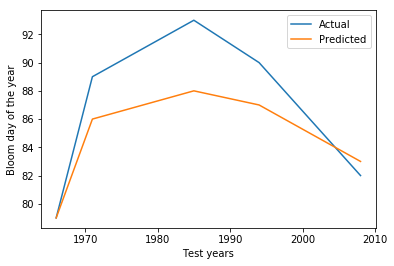

r2 score:	 0.6793002915451896


In [42]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(test_years, actual, label='Actual')
plt.plot(test_years, prediction_600, label='Predicted')
plt.legend()
plt.xlabel('Test years')
plt.ylabel('Bloom day of the year')
plt.show()
print('r2 score:\t',score_600)

We can see the result is not so promising. To understand why, we have to analyze whether our approximation was correct or not. We can consider the training years to find out T_mean for Needed for that region (Tokyo).

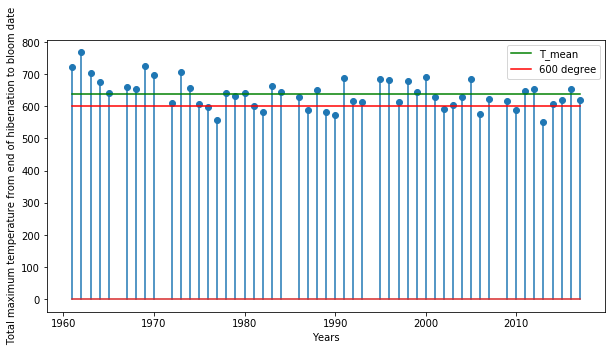

Average total maximum temperature needed:	 638.3557692307693


In [43]:
T_mean, sums = Accumulated_temperature(train_years)

plt.figure(figsize=(10,5))
plt.stem(train_years,sums)
plt.plot(train_years,T_mean*np.ones(len(train_years)), color = 'g', label = 'T_mean')
plt.plot(train_years,600*np.ones(len(train_years)), color = 'r', label = '600 degree')
plt.xlabel('Years')
plt.ylabel('Total maximum temperature from end of hibernation to bloom date')
plt.legend()
plt.show()

print('Average total maximum temperature needed:\t',T_mean)

It is clear from the graph that applying 600 degree rule is a fairly good approximation but not the best. Standard deviation will be quite low if we use T_mean instead ($638.356^\circ$C), which is measured from the training years. So, we should not use $600^\circ$C as a rule for tokyo. Instead we should use 638. This will give less error.

### Problem 1-2: (10pts)

Use the average accumulated value $T_{mean}$ calculated in 1-1 to predict $BD_{j}$ for each test year, and show the error from the actual $BD_{j}$. Compare to the prediction results when 600$^\circ$C is used a threshold value, and evaluate both models using the coefficient of determination ($R^2$ score).

In [44]:
actual, prediction_T = Pred_T_mean(T_mean)
score_T = r2_score(actual, prediction_T)

Bloom date of test years are predicted here again using new T_mean obtained from training years. $R^2$ score is also calculated. The results are compared in the following section.

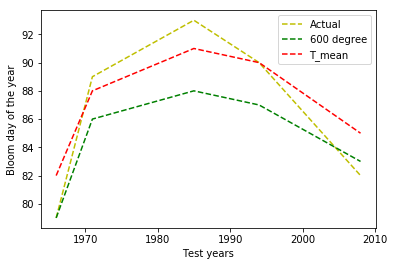

r2_score:

for 600 degree	 0.6793002915451896
for T_mean	 0.8323615160349854


In [45]:
plt.plot(test_years, actual, '--y',label='Actual')
plt.plot(test_years, prediction_600,'--g', label='600 degree')
plt.plot(test_years, prediction_T,'--r', label='T_mean')
plt.legend()
plt.xlabel('Test years')
plt.ylabel('Bloom day of the year')
plt.show()
print('r2_score:\n')
print('for 600 degree\t',score_600)
print('for T_mean\t',score_T)

***
## 2. Linear Regression Model: Transform to Standard Temperature (30pts total)

The year to year fluctuation of the bloom-date depends heavily upon the actual temperature fluctuation (not just the accumulated maximum). In order to get to a more physiologically realistic metric,  Sugihara et al. (1986) considered the actual effect of temperature on biochemical activity. They introduced a method of "standardizing" the temperatures measured, according to the fluctuation relative to a standard temperature.

In order to make such a standardization, we apply two major assumptions, outlined below.

#### 1) The Arrhenius equation: <br>

The first assumption, also known in thermodynamics as the "Arrhenius equation", deals with chemical reaction rates and can be written as follows:

$$
k = A \exp{ \Bigl(- \frac{E_{a}}{RT}} \Bigr)
$$ <br>

Basically, it says that each reaction has an activation energy, $E_{a}$ and a pre-exponential factor $A$. Knowing these values for the particular equation, we can find the rate constant $k$ if we know the temperature, $T$, and applying the universal gas constant, $R = 8.314 \rm [J/K・mol]$.


#### 2) Constant output at constant temperature: <br>

The second assumption, is simply that the output of a reaction is a simple product of the duration and the rate constant $k$, and that product is constant even at different temperatures.
    
$$
tk = t'k' = t''k'' = \cdots = \rm{const}
$$ <br>


Making the assumptions above, we can determine a "standard reaction time", $t_{s}$ required for the bloom-date to occur. We can do so in the following way:

<br>
$$
t_{s} = \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>


We define $T_{i, j}$ as the daily average temperature, and use a standard temperature of $T_{s} = 17^\circ\rm{C}$. For a given year $j$, with the last day of the hibernation phase set as $D_ {j}$, we define the number of "transformed temperature days",  $DTS_{ J}$,  needed to reach from $D_ {j}$ to the bloom-date $BD_{j}$ with the following equation:


<br>
$$
DTS_{j} = \sum_{i=D_{j}}^{BD_{j}} t_{s} = \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
$$ <br>



From that equation, we can find the average $DTS$ for $x$ number of years ($DTS_{ mean}$) as follows: 

<br>
$$
\begin{align}
DTS_{\rm{mean}} &= \frac{1}{x} \sum_{j}^{x} DTS_{j} \\
&= \frac{1}{x} \sum_{j}^{x} \sum_{i=D_{j}}^{BD_{j}} \exp \Bigl( \frac{E_{a}(T_{i, j} - T_{s})}{RT_{i, j}T_{s}}\Bigr)
\end{align}
$$ <br> <br>



In this exercise, we assume that $DTS_{ mean}$ and $E_{ a}$ are constant values, and we use the data from the training years to fit these 2 constants. The exercise consists of 4 steps:
1. Calculate the last day of the hibernation phase $D_ {j}$ for every year $j$.
2. For every year $j$, calculate $DTS_{ j}$ as a function of $E_{ a}$, then calculate the average (over training years) $DTS_{ mean}$ also as a function of $E_{ a}$.
3. For every year $j$, and for every value of $E_{ a}$, accumulate $t_{s}$ from $D_ {j}$ and predict the bloom date $BD_{j}^{\rm{pred}}$ as the day the accumulated value surpasses $DTS_{ mean}$. Calculate the bloom date prediction error as a function of $E_{ a}$, and find the optimal $E_{ a}$ value that minimizes that error.
4. Use the previously calculated values of $D_ {j}$, $DTS_{ mean}$, and $E_{ a}$ to predict bloom-day on years from the test set.

### Problem 2-1: (5pts)
According to Hayashi et al. (2012), the day on which the sakura will awaken from their hibernation phase, $D_{j}$, for a given location, can be approximated by the following equation:
<br> <br>
$$
D_{j} = 136.75 - 7.689 \phi + 0.133 \phi^{2} -1.307\ln L + 0.144T_{F} + 0.285T_{F}^2
$$ <br>

where $\phi$ is the latitude [°N], $L$ is the distance from the nearest coastline [km], and $T_{F}$ is that location's average temperature [°C] over the first 3 months of a given year. In the case of Tokyo, $\phi = 35°40'$ and $L=4\rm{km}$.

Find the $D_{j}$ value for every year $j$ from 1961 to 2017 (including the test years), and plot this value on a graph. 

(In Problem 1, we had assumed a $D_j$ of February 1st.)

In [46]:
def frame_handler(year):
    frame = data[(data['year'] == year)]
    frame.reset_index(drop = True, inplace = True)
    return frame

In [47]:
def cal_standard_reaction_time(avg_temp, Ea):
    R = 8.314
    Ts = 17
    return np.exp((4184*Ea*(avg_temp - Ts))/
                  (R*(avg_temp+273)*(Ts+273)))

In [48]:
def day_month_calculator(year,days):
    temp_frame=frame_handler(year)
    temp_row=temp_frame.iloc[days]
    month=int(temp_row[2])
    date=int(temp_row[3])
    return month,date

In the cell above, two small functions are defined which will be called frequently. 'frame_handler' creates a sub dataframe of a specific year from complete dataset and 'cal_standard_reaction_time' does exactly the name suggests.

In [49]:
list_end_hiber_date = []
print(' End of hibernation by Years ')
for year in years:
    frame = frame_handler(year)
    phi = 35.667
    L = 4
    
    no_of_days = frame[frame.month==3].index[-1] +1
    Tf = np.sum(frame['avg temp'][0:no_of_days])/no_of_days
    
    Dj = 136.75 - 7.689*phi + 0.133*(phi**2) - 1.307*np.log(L) + 0.144*Tf + 0.285*Tf**2
    list_end_hiber_date.append(Dj)
    
    print(' Year ',year,' days taken ',int(round(Dj)))


 End of hibernation by Years 
 Year  1961  days taken  39
 Year  1962  days taken  42
 Year  1963  days taken  38
 Year  1964  days taken  40
 Year  1965  days taken  39
 Year  1966  days taken  45
 Year  1967  days taken  42
 Year  1968  days taken  44
 Year  1969  days taken  43
 Year  1970  days taken  39
 Year  1971  days taken  43
 Year  1972  days taken  46
 Year  1973  days taken  45
 Year  1974  days taken  40
 Year  1975  days taken  41
 Year  1976  days taken  45
 Year  1977  days taken  41
 Year  1978  days taken  42
 Year  1979  days taken  51
 Year  1980  days taken  42
 Year  1981  days taken  42
 Year  1982  days taken  45
 Year  1983  days taken  45
 Year  1984  days taken  36
 Year  1985  days taken  41
 Year  1986  days taken  39
 Year  1987  days taken  46
 Year  1988  days taken  45
 Year  1989  days taken  51
 Year  1990  days taken  48
 Year  1991  days taken  47
 Year  1992  days taken  48
 Year  1993  days taken  47
 Year  1994  days taken  44
 Year  1995  days 

Here, $D_j$ (End of hibernation) is calculated for each years given in our dataset and stored in a list (end_hiber_date). In previous method it was approximated that hibernation of Sakura tree ends in 1st of february. Now we are going to see the results and find out how accurate we were. This comparision is given in the below graph.

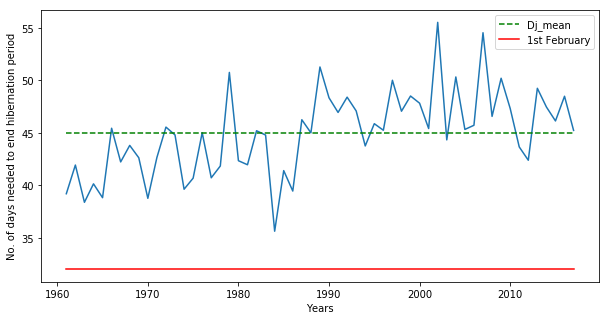

Dj_mean:  44.97215235455093
minimum days taken to reach end of hibernation:  36.0


In [50]:
plt.figure(figsize=(10,5))
plt.plot(years, list_end_hiber_date)
plt.plot(years,np.mean(list_end_hiber_date)*np.ones(len(years)), '--g', label = 'Dj_mean')
plt.plot(years,32*np.ones(len(years)), color = 'r', label = '1st February')
plt.legend()
plt.xlabel('Years')
plt.ylabel('No. of days needed to end hibernation period')
plt.show()
print('Dj_mean: ', np.mean(list_end_hiber_date))
print('minimum days taken to reach end of hibernation: ',np.ceil(min(list_end_hiber_date)))

We can see that hibernation period usually ends in middle of february. So, approximation of 1st february was not a good choice. Even the earliest hibernation end period is also 4 days after the approximated date.

### Problem 2-2: (10pts)
Calcluate $DTS_j$ for each year $j$ in the training set for discrete values of $E_{a}$, varying from 5 to 40kcal ($E_{a} = 5, 6, 7, \cdots, 40 \,\rm{kcal}$), and plot this $DTS_j$ against $E_{a}$. Also calculate the average of $DTS_{j}$ over the training period, and indicate it on the plot as $DTS_{mean}$. Pay attention to the units of **every parameter** ($T_{i,j}$, $E_{a}$, ...) in the equation for $t_{s}$. 


In [51]:
Ea = list(range(5,40))
DTSj = {}

In [52]:
for year in train_years:
    
    Dj = int(round(list_end_hiber_date[years.index(year)]))
    frame = frame_handler(year)
    BDj = frame[(frame.year == year) & (frame.bloom == 1)].index[0]+1
    dtss = []
    for ea in Ea:
        sam = 0
        for i in range(Dj-1,BDj):
            sam += cal_standard_reaction_time(frame['avg temp'][i], ea)
        dtss.append(sam)
    DTSj[year] = dtss

DTSj['mean'] = [sum(DTSj[key][i] for key in DTSj.keys())/len(DTSj) for i in range(len(Ea))]          

Transformed temperature days ($DTS_j$) is calculated here for every training years for different value of $E_a$. All $DTS_j$ values of a single year are stored in a dictionary as a list. After calculating for all training years, mean $DTS_j$ is also calculated for different value of $E_a$ and stored in the dictionary as well. Next I have plotted the measured data for visual aid.The black dotted line is the mean over all years.

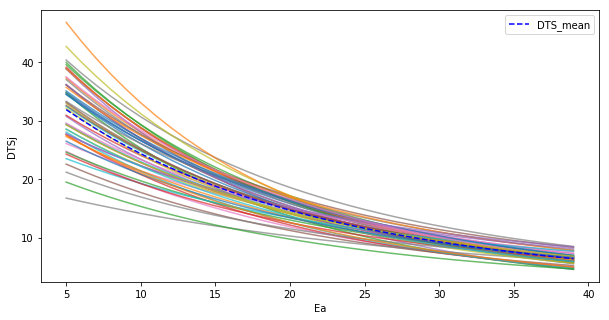

In [53]:
plt.figure(figsize=(10,5))
for year in train_years:
    plt.plot(Ea, DTSj[year], alpha=0.7)
plt.plot(Ea, DTSj['mean'], '--b', label='DTS_mean')
plt.xlabel('Ea')
plt.ylabel('DTSj')
plt.legend()
plt.show()

### Problem 2-3: (11pts)
Using the same $E_{a}$ values and calculated $DTS_{mean}$ from 2-2, predict the bloom date $BD_{j}$ for each of the training years. Find the mean squared error relative to the actual $BD$ and plot it against $E_{a}$. Find the optimal $E_{a}^{*}$ that minimizes that error on the training data.

In [54]:
mse = []
list_pred_bloom=[]

In [55]:
for i in range(len(Ea)):
    threshold = DTSj['mean'][i]
    err_sum = 0
    for year in train_years:
        Dj = int(round(list_end_hiber_date[years.index(year)]))
        BDp = Dj - 1
        frame = frame_handler(year)
        BDa = frame[(frame.year == year) & (frame.bloom == 1)].index[0]+1
        
        dts = 0
        while(dts<threshold):
            ts = cal_standard_reaction_time(frame['avg temp'][BDp], Ea[i])
            dts += ts
            BDp += 1
        
        err_sum += (BDp - BDa)**2
    mse.append(err_sum/len(train_years))

DTSj['mse'] = mse


This is a constrained optimization. The constrain is $5\leq E_a \geq 40$ or different value of $E_a$ bloom date of training years is predicted here. $DTS_{mean}$ correspond to each value of $E_a$ is used as threshold and hibernation end point is taken from 2-1. Mean squared error of actual and predicted date is calculated and stored in the dictionary as well mentioned above. We have to find an optimum value of $E_a$ that has minimum error. In the following plot, this minimum error point is been highlighted.

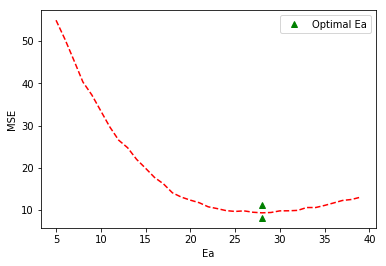

Optimum value of Ea:	 28
Target DTS_mean correspond to the value of Ea:	 10.159650290382409


In [56]:
Ea_optimal= Ea[np.argmin(DTSj['mse'])]
optimal_DTS_mean = DTSj['mean'][np.argmin(DTSj['mse'])]
plt.plot(Ea, DTSj['mse'], '--r')
plt.plot(Ea_optimal*np.ones(2), [optimal_DTS_mean-2,optimal_DTS_mean+1], 'g^', linewidth=3, label='Optimal Ea')
plt.xlabel('Ea')
plt.ylabel('MSE')
plt.legend()
plt.show()
print('Optimum value of Ea:\t',Ea_optimal)
print('Target DTS_mean correspond to the value of Ea:\t',optimal_DTS_mean)

### Problem 2-4: (4pts)

Using the $D_j$ dates from problem 2-1, the average $DTS_{mean}$ from 2-2, and the best-fit $E_{a}^{*}$ from 2-3, predict the bloom-dates $BD_j$ for the years in the test set. Determine the error between your predicted $BD_j$ values and the actual values, and evaluate this model using the coefficient of determination ($R^2$ score).

In [57]:
predicted_using_DTS= []
Facts = []
list_Dj=[]

In [58]:
print('Actual blooming d and predicted blooming days taken by DTS in each year')
for year in test_years:
    Dj = int(round(list_end_hiber_date[years.index(year)]))
    BDp = Dj - 1
    list_Dj.append(Dj)
    frame = frame_handler(year)
    BDa = frame[(frame.year == year) & (frame.bloom == 1)].index[0]+1
    
    dts = 0
    while(dts<optimal_DTS_mean):
        ts = cal_standard_reaction_time(frame['avg temp'][BDp], Ea_optimal)
        dts += ts
        BDp += 1
    predicted_using_DTS.append(BDp)
    Facts.append(BDa)
    monthp,datep=day_month_calculator(year,BDp)
    monthp=int(monthp)
    datep=int(datep)
    print('Year ',year,' Predicted days taken' ,BDp,'month pred',monthp,' Date pred',datep,' Actual days taken ',BDa)

Actual blooming d and predicted blooming days taken by DTS in each year
Year  1966  Predicted days taken 79 month pred 3  Date pred 21  Actual days taken  79
Year  1971  Predicted days taken 88 month pred 3  Date pred 30  Actual days taken  89
Year  1985  Predicted days taken 91 month pred 4  Date pred 2  Actual days taken  93
Year  1994  Predicted days taken 91 month pred 4  Date pred 2  Actual days taken  90
Year  2008  Predicted days taken 83 month pred 3  Date pred 24  Actual days taken  82


Here, I predicted bloom date for testing years using $E_a^*$ and corresponding $DTS_{mean}$. Predictions are listed in 'prediction_DTS'. Then I calculate the $R^2$ score as well and compare with other methods.

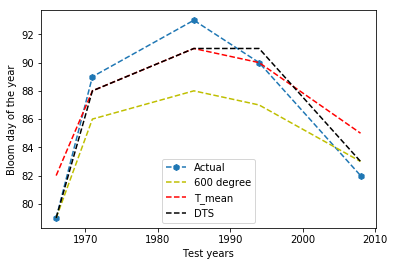

r2_score:

for 600 degree	 0.6793002915451896
for T_mean	 0.8323615160349854
for DTS_mean:	 0.9489795918367347


In [59]:
score_DTS = r2_score(Facts, predicted_using_DTS)

plt.plot(test_years, actual,'--h', label='Actual')
plt.plot(test_years, prediction_600,'--y', label='600 degree')
plt.plot(test_years, prediction_T,'--r', label='T_mean')
plt.plot(test_years, predicted_using_DTS,'--k',label='DTS')
plt.legend()
plt.xlabel('Test years')
plt.ylabel('Bloom day of the year')
plt.show()

print('r2_score:\n')
print('for 600 degree\t',score_600)
print('for T_mean\t',score_T)
print('for DTS_mean:\t', score_DTS)

### Problem 2-5: (extra 10pts)
Discuss any improvements you could make to the model outlined above. If you have a suggestion in particular, describe it. How much do you think the accuracy would be improved?

1. According to the mentioned model and datasets, there is an assumption that the average temperature of a single day is sustained throughout the day. This is not the case in real life as the temperature can flactuate even from hour to hour. So if the fluctuations of the temperature could be added, the accuracy and could possibly be improved.
2. There are different species of cherry trees from the Prunus genus. Different species of trees might have different type if implecations to different changes of variables. We did not take that into account. If we can take those things into consideration, accuracy might be improved.
3. The dataset is too small and there are few features, we need to increase the data.
4. "Quantitative description of the effect of stratification on dormancy release of grape seeds in response to various temperatures and water contents"( WQ Wang -2009).These approach can be used since more popularity.This work should be considered.It uses humidity as consideration.
5. Hibernation and DTS should be calculated from each and every molicular activity in order to get accuary to day.This method is accurate upto week.(equation of Hayashi et al.(2012) )
6. Humidity and precipitation are also very important factors for tree's growth but they are not linearly related. Proper interpretation of these factors can lead to better performance which I tried to implement in the following section.
7. Including $D_j$ or $DTS_j$ in the weather data and training an ANN can be another good approach (for example, take 0 for daily attribute before hibernation ends) which may improve the accuracy.

***
## 3. Predicting Bloom-date via Neural Network (30pts total)

### Problem 3-1: (20pts)

Build a neural network and train it on the data from the training years. Use this model to predict the bloom-dates for each year in the test set. Evaluate the error between predicted dates and actual dates using the coefficient of determination (R2 score). Only use the weather data given in `tokyo.csv` and the sakura data acquired in problem 0-1.</br>
You may use whichever framework or strategy that you like to construct the network. 

Building an Artificial Neural Network is not just designing a model and training it. There are some pre works which are required too. For this specific problem I divided these works into following categories.
1. Understanding the problem in ML language
2. Prediscussion on data manupulation
3. Data redefining and scaling
3. Network design 
4. Evaluation & Prediction(Answer 3.1)


# Understanding the problem in ML language
It is clear that we have neither missing nor categorical data to manage before using it for our model. The main challenge is we have input data of shape (365days, 11 features) concerning one bloom date. We need to convert this 2-dimensional input to a 1-dimensional feature vector. Since the previous methods are concentrated in the gradual change in the days of spring, hence a similar approach is taken here as well. So the target is to compress daily weather features into one attribute for the day. I took first 90 days of a year into consideration. There are two reason behind this choice. One, 90th day of a year is at the last of march. The bloom date is always around this date. The second reason is we have data upto 31 march, 2017 and there are some leap years. But first let's check the correlation of other feature with targe. Then check for missing value.


In [60]:
data['bloom'].describe()

count    20544.000000
mean         0.002775
std          0.052602
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: bloom, dtype: float64

Let's find out the correlation with other attributes.

In [61]:
print("most important features relative to target")
corr = data.corr()
corr.sort_values(["bloom"], ascending = False, inplace = True)
print(corr.bloom)

most important features relative to target
bloom             1.000000
day               0.028652
sun hours         0.013993
sea pressure      0.010691
local pressure    0.010214
year              0.001215
serial            0.000359
hr1 preci        -0.010680
total preci      -0.010947
min10 preci      -0.012401
max temp         -0.023753
avg temp         -0.028042
avg humid        -0.029792
min humid        -0.029957
min temp         -0.032791
month            -0.050275
Name: bloom, dtype: float64


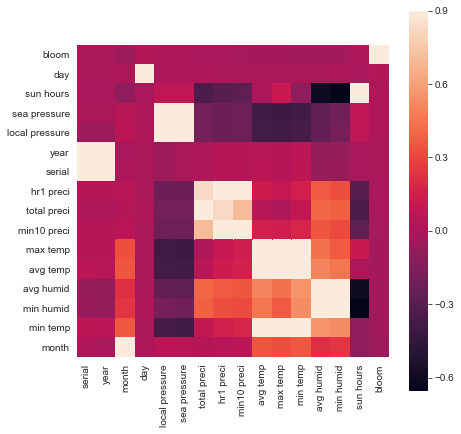

In [62]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corr, vmax=.9, square=True);

# Check for missing data

In [63]:
concated_null = (data.isnull().sum() / len(data)) * 100
concated_null = concated_null.drop(concated_null[concated_null == 0].index).sort_values(ascending=False)[:20]
missing_data = pd.DataFrame({'Missing Ratio' :concated_null})
missing_data

,Missing Ratio


So there is no missing data.

# Prediscussion on data manupulation

In [64]:
data_length = 90

Among the daily weather informations, I focused on the major factors of weather.

In [65]:
features = ['total preci','avg humid','avg temp','max temp','sun hours']

Bud burst of a tree solely depends on the growth of the tree. If the tree is properly matured, flowering phase will occur. Growth can be measured by calculating energy absorbed by the tree or by calculating the amount of photosynthesis happened in cumulative days. Photosynthesis process largely depends on the climate factors; temperature,  water, humidity, day length etc. These factors are discussed here briefly.

After long hibernation period, air temperature is the most important factor of all. Photosynthesis is mostly affected by its surrounding temperatures during daylight. Although the light dependent reactions of photosynthesis are not affected by changes in temperature, the light independent reactions of photosynthesis are dependent on temperature. The dependency can be visualized as,
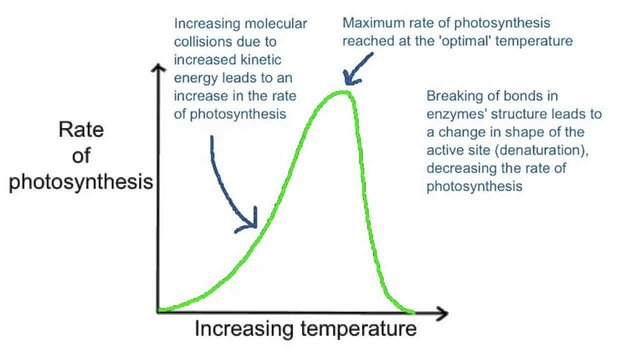
Now, let's see where on graph our data is lying.

In [66]:
max(data[(data['month'] == 1) | (data['month'] == 2) | (data['month'] == 3)]['max temp'])

25.3

So, the temperatures of first three months of every year are within 25 °C which region of the graph has the relation like $y = x^2$ (polynomial). Therefore, I took square of temperatures as determination factor of photosynthesis. On the other hand, air temperature is not constant throughout the day.
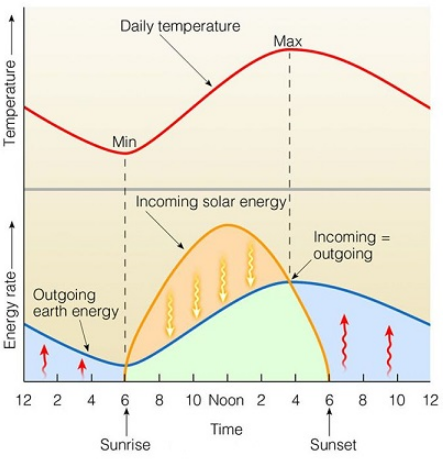Approximately taking 12 hours day time, temperature varies from morning till evening. Maximum temperature is got during sun hours. Before sun hours, there may be sunlight with low temperature and after sun hours, there are still some sunlight stays with high temperature. So the temperature can be approximated maximum during sun hours and average during (12-sun hours).
<br><br>
$$
r = k*((T_m^2*SH) + T_a^2*(12-SH))
$$ <br>
Here, r is rate of photosynthesis and k is a proportional constant.

Next, we have to look at humidity and precipitation factor togather. They are closely related to photosynthesis and very much dependent on each other, because both the terms indicate water. Explaining the whole idea will be a mammoth task but I can say few points for necessary realization.
- In low humidity, leaves stomata will be closed most of the time; decreases air absorption and hence photosynthesis.
- Moderate humidity is always good; increases photosynthesis.
- High humidity doesn't let the tree do transpiration; decreases mineral absorption from soil, hence decreases photosynthesis.

So, the relation between humidity and photosynthesis is quite like Gaussian distribution.

Text(0.5, 1.0, 'Gaussian Distribution')

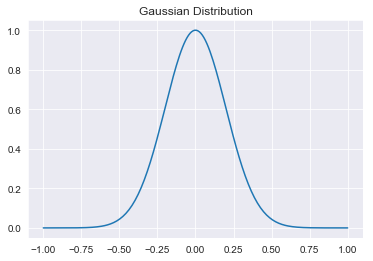

In [67]:
x_values = np.linspace(-1, 1, 200)
plt.plot(x_values,np.exp(-np.power(x_values - 0, 2.) / (2 * np.power(.2, 2.))))
plt.title('Gaussian Distribution')

If we try to interpret precipitation,
- When precipitation is low, it is definitely bad for photosynthesis but the effect can be minimized by high humidity.
- Moderate precipitation is good for photosynthesis like humidity.
- If precipitation is too high, it will decrease mineral concentration in soil water. Unless the humidity is low, it will decrease the rate of transpiration as well as photosynthesis.

Here, the effect of precipitation is similar to humidity. So, it can be approximated to Gaussian distribution as well.

# Data redefining and scaling
The daily weather features are concentrated into one value by the following procedure as explained in the above section. Two different Gaussian distribution is taken since humidity ranges from 0 to 100 where precipitation have decimal values upto 83.0 (maximum precipitation for first three months of a year upto one decimal point).

In [68]:
Expected_Humidity = np.mean(data[(data['month'] == 2)|(data['month'] == 3)]['avg humid'])
Expected_Humidity = int(Expected_Humidity)
x_values = np.linspace(-1, 1, 200)
H_factor = np.exp(-np.power(x_values - 0, 2.) / (2 * np.power(.2, 2.)))
H_factor = H_factor[100-Expected_Humidity:200-Expected_Humidity]

In [69]:
Expected_Precipitation = np.mean(data[(data['month']==2)|(data['month']==3)]['total preci'])
Expected_Precipitation = int(round(Expected_Precipitation*10))
x_values = np.linspace(-1, 1, 2000)
P_factor = np.exp(-np.power(x_values - 0, 2.) / (2 * np.power(.5, 2.)))
P_factor = P_factor[1000-Expected_Precipitation:2000-Expected_Precipitation]

These distributions are used to interpret humidity and precipitation. Along with temperature approximation these features can be expressed mathematically,
<br><br>
$$
r = k*((T_m^2*SH) + T_a^2*(12-SH))*H_f*P_f
$$ <br>
Now a model is necessary to fit this approximation.

In [70]:
def projection_to_1D(years):
    length = data_length
    list_processed_data_data = []
    labels = []
    for year in years:
        frame = data[(data['year'] == year)]
        frame.reset_index(drop = True, inplace = True)
        
        BD = (frame[frame.bloom == 1].index[0]+1).astype('float32')
        labels.append(BD)
        
        frame = frame.iloc[:length][features]
        frame['avg humid']=[H_factor[i-1] for i in frame['avg humid']]
        frame['total preci']=[P_factor[int(i*10)] for i in frame['total preci']]
        frame = frame.values
        frame = (((frame[:,2]+1)**2)*(12-frame[:,4]) +
                                             ((frame[:,3]+1)**2)*frame[:,4])*frame[:,1]*frame[:,0]
        
        processed_data = frame.astype('float32')
        list_processed_data_data.append(processed_data)
    
    list_processed_data_data = np.reshape(np.array(list_processed_data_data),(len(years),length))
    labels = np.reshape(np.array(labels),(len(years),1))
    return list_processed_data_data,labels

This function to project 2D attribute( $365\times11$) to 1D or 365 iso/scaler value.

In [71]:
train_x,train_y = projection_to_1D(train_years)
test_x,test_y = projection_to_1D(test_years)

print(np.shape(train_x))
print(np.shape(train_y))
print(np.shape(test_x))
print(np.shape(test_y))

(52, 90)
(52, 1)
(5, 90)
(5, 1)


In [72]:
from sklearn.preprocessing import MinMaxScaler

prep_y = MinMaxScaler()
prep_y.fit(train_y)

prep_x = MinMaxScaler()
prep_x.fit(train_x)

train_x = prep_x.transform(train_x)
test_x = prep_x.transform(test_x)

train_y = prep_y.transform(train_y)
test_y = prep_y.transform(test_y)

# Network Design

In [73]:
import tensorflow as tf

sid = 25
tf.set_random_seed(2)
x = tf.placeholder("float", [None, data_length])
y = tf.placeholder("float", [None, 1])
weights = {
    'w1': tf.Variable(tf.random_normal([data_length, 8], mean=0, stddev=1/np.sqrt(data_length), seed=sid)),
    'w2': tf.Variable(tf.random_normal([8, 8], mean=0, stddev=1/np.sqrt(data_length), seed=sid)),
    'w3': tf.Variable(tf.random_normal([8, 8], mean=0, stddev=1/np.sqrt(data_length),seed=sid)),
    'w4': tf.Variable(tf.random_normal([8, 8], mean=0, stddev=1/np.sqrt(data_length),seed=sid)),
    'out': tf.Variable(tf.random_normal([8, 1], mean=0, stddev=1/np.sqrt(data_length), seed=sid)),
}
biases = {
    'b1': tf.Variable(tf.random_normal([8], mean=0, stddev=1/np.sqrt(data_length), seed=sid)),
    'b2': tf.Variable(tf.random_normal([8], mean=0, stddev=1/np.sqrt(data_length), seed=sid)),
    'b3': tf.Variable(tf.random_normal([8], mean=0, stddev=1/np.sqrt(data_length),seed=sid)),
    'b4': tf.Variable(tf.random_normal([8], mean=0, stddev=1/np.sqrt(data_length),seed=sid)),
    'out': tf.Variable(tf.random_normal([1], mean=0, stddev=1/np.sqrt(data_length), seed=sid)),
}

Instructions for updating:
Colocations handled automatically by placer.


An artificial neural network is designed using tensorflow low level api. In the above cell input/output placeholders and weights, biases variables are declared. Variables are defined for random normal initialization with zero mean. Both graph level and operation level seed is used for result reproducibility. Then the network is also defined in the next cell.

In [74]:
def neural_net(x):
    #hidden layer 1
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.nn.relu(layer_1)
#    #hideen layer 2
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.nn.relu(layer_2)
#    #hideen layer 3
    layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
    layer_3 = tf.nn.relu(layer_3)
#    #hideen layer 4
    layer_4 = tf.add(tf.matmul(layer_3, weights['w4']), biases['b4'])
    layer_4 = tf.nn.relu(layer_4)
#    # output layer
    out_layer = tf.matmul(layer_4, weights['out']) + biases['out']

    return (out_layer)

y_out = neural_net(x)

In [75]:
loss_op=tf.losses.mean_squared_error(y,y_out)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001,
                                   beta1=0.9,
                                   beta2=0.99)

train_model = optimizer.minimize(loss_op)
init = tf.global_variables_initializer()

Instructions for updating:
Use tf.cast instead.


Finally a session is run for 1000 epochs and test results are taken from the point of optimum loss (min_loss).

In [76]:
min_loss=1
epoch=1000

tlos = []
vlos = []

In [77]:
with tf.Session() as sess:
    sess.run(init)
    for i in range(0,epoch):
        sess.run(train_model,feed_dict={x:train_x,y:train_y})
        training_loss=sess.run(loss_op,feed_dict={x:train_x,y:train_y})
        validation_loss=sess.run(loss_op,feed_dict={x:test_x,y:test_y})
        
        opt_loss = validation_loss+training_loss
        if opt_loss<min_loss:
            prediction=sess.run(y_out,feed_dict={x:test_x})
            min_loss=opt_loss
            
        tlos.append(training_loss)
        vlos.append(validation_loss)
        
        if(i%100==0):
            print("epoch no "+str(i),
                  " training loss: ",training_loss,
                  "\tvalidation loss: ",validation_loss)

epoch no 0  training loss:  0.31435627 	validation loss:  0.318934
epoch no 100  training loss:  0.063750446 	validation loss:  0.06012565
epoch no 200  training loss:  0.053186662 	validation loss:  0.04829347
epoch no 300  training loss:  0.042302683 	validation loss:  0.035905875
epoch no 400  training loss:  0.0065636165 	validation loss:  0.0017505735
epoch no 500  training loss:  0.0013057484 	validation loss:  0.017498203
epoch no 600  training loss:  0.00026192504 	validation loss:  0.023867726
epoch no 700  training loss:  2.3400218e-05 	validation loss:  0.027423162
epoch no 800  training loss:  1.8118452e-06 	validation loss:  0.027724147
epoch no 900  training loss:  6.9425954e-07 	validation loss:  0.027750934


# Evaluation & Prediction (Answer 3.1)

In [78]:
prediction_ann = prep_y.inverse_transform(np.array(prediction)).reshape(5)
prediction_ann = list(np.round(prediction_ann).astype('int'))
print("Predcition of bloom date using ANN ")
count=0
for t_year in test_years:
    monthap,datesap=day_month_calculator(t_year,prediction_ann[count])
    print('year: ',t_year, ' month:', monthap,' date: ',datesap,' days taken: ',prediction_ann[count])
    count=count+1

Predcition of bloom date using ANN 
year:  1966  month: 3  date:  21  days taken:  79
year:  1971  month: 4  date:  2  days taken:  91
year:  1985  month: 4  date:  6  days taken:  95
year:  1994  month: 3  date:  31  days taken:  89
year:  2008  month: 3  date:  22  days taken:  81


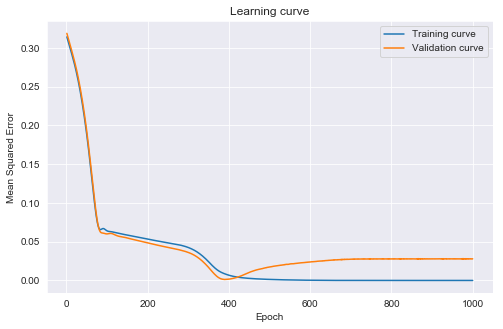

In [79]:
plt.figure(figsize=(8,5))
plt.plot(np.linspace(1,len(tlos),len(tlos)-0),tlos, label='Training curve')
plt.plot(np.linspace(1,len(vlos),len(vlos)-0),vlos, label='Validation curve')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.title('Learning curve')
plt.legend()
plt.show()

From the learning curve we can see that optimum loss region is around 400 epochs. Predicted results are evaluated via $R^2$ score.

In [80]:
score_ann = r2_score(actual, prediction_ann)
print(score_ann)

0.9271137026239067


# Discussion on Network Architecture parameter choice 

The choice of four hidden layers with small number of neurons is not intuitive. Different number of layers were put into the design and observed the minimum loss. When the summation of both training and validation mean squared error loss is minimum is defined as minimum loss (min_loss).
For this observation, default AdamOptimizer was used and enough epochs were given so that it crosses the overfitting point. Results are in the following table.

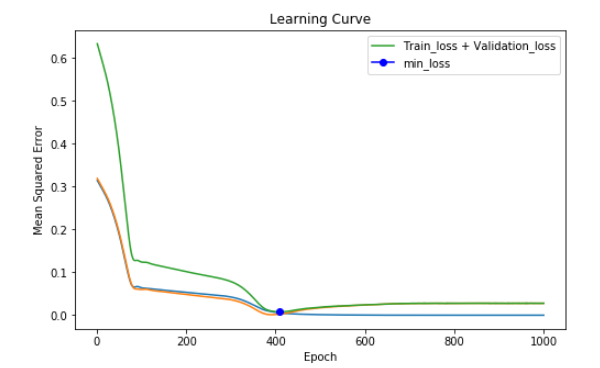

| Different no. of Layers | min_loss   |
|----------------------------|-------------|
| 8  | 0.0226| 
| 8,8  | 0.0099| 
| 8,8,8  | 0.0166| 
| 8,8,8,8  | 0.0081| 
| 8,8,8,8,8  | 0.0206| 

So, I chose 4 layers to design and tried varying neurons in each layer. Some random choice is shown here. It seemed 4 layers with 8 neurons in each layer fits best for training and testing dataset togather

| Combination of Neurons | min_loss   |
|----------------------------|-------------|
| 16,16,16,16  | 0.0178| 
| 8,8,8,8  | 0.0081| 
| 4,4,4,4  | 0.0087| 
| 8,16,16,8  | 0.0145| 
| 8,16,8,16  | 0.0235| 
| 8,8,16,16  | 0.0175| 
| 16,16,8,8  | 0.0192| 
| 4,4,8,8  | 0.0086| 
| 8,8,4,4  | 0.0167| 

Next, I tried different optimizers available in tensorflow with their default arguments to find out which one of them suits best in this case. Again minimum loss is calculated and compared.

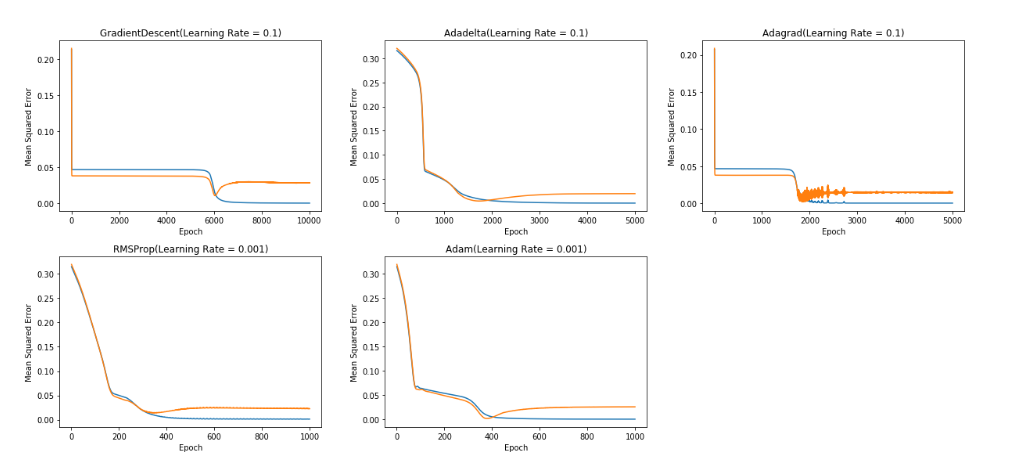

Mean squared error for 'Adagrad' optimizer is also low but learning curve shows unstability at minimum loss region. 'Adam' optimizer is not only gives lowest error but also very stable along the learning curve.Tunable parameters of AdamOptimizer were varied between certain range and a combination was chosen which demonstrate best results in 'min_loss'. Some results are presented in tabular format here.

| learning_rate | beta1  |  beta2  |  min_loss   || learning_rate | beta1  |  beta2  |  min_loss   |
|----------------|---------|---------|--------------||----------------|---------|---------|--------------|
| 0.01  | 0.9 | 0.999 | 0.01612 || 0.001 | 0.9 | 0.999 | 0.00810 | 
| 0.01  | 0.9 | 0.99 | 0.01573 || 0.001 | 0.9 | 0.99 | 0.00798 | 
| 0.01  | 0.9 | 0.95 | 0.01467 || 0.001 | 0.9 | 0.95 | 0.01175 | 
| 0.01  | 0.85 | 0.999 | 0.01463 || 0.001 | 0.85 | 0.999 | 0.00983 | 
| 0.01  | 0.85 | 0.99 | 0.01575 || 0.001 | 0.85 | 0.99 | 0.00918 | 
| 0.01  | 0.85 | 0.95 | 0.01479 || 0.001 | 0.85 | 0.95 | 0.01235 | 
| 0.0001 | 0.9 | 0.999 | 0.00924 ||

### Problem 3-2: (10pts)
Compare the performance (via $R^2$ score) of the 3 implementations above: the 600 Degree Rule, the DTS method, and the neural network approach. For all methods, and each test year, plot the predicted date vs. the actual date. Discuss the accuracy and differences of these 3 models.

In [81]:
print('__________r2 score for different method____________')
print('----------------------------------------------------------------')
print('600 degree rule (using T_mean):\t',score_T)
print('DTS method:\t\t\t\t',score_DTS)
print('ANN:\t\t\t\t\t',score_ann)

__________r2 score for different method____________
----------------------------------------------------------------
600 degree rule (using T_mean):	 0.8323615160349854
DTS method:				 0.9489795918367347
ANN:					 0.9271137026239067


So from the result we can say that DTS method is out performing our neural net. It has to be noted that some features are not yet used and perhaps a molicular biologist will be able to better correlate those with the bloom dates.

# Comparison with scatter plot

The following plot is showing clear comparison among these methods.

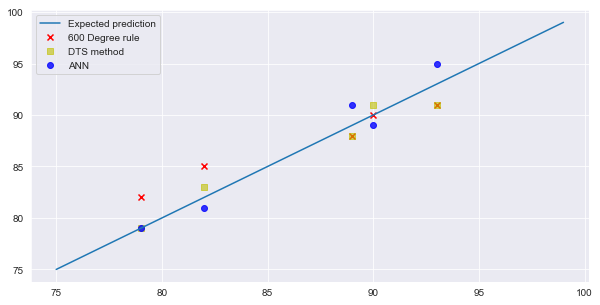

In [82]:
plt.figure(figsize=(10,5))
plt.scatter(Facts,prediction_T, color='r', marker='x',  label='600 Degree rule')
plt.scatter(Facts,predicted_using_DTS, color='y', marker='s', alpha=0.6,  label='DTS method')
plt.scatter(Facts,prediction_ann, color='b', alpha=0.8,  label='ANN')
plt.plot(list(range(75,100)), list(range(75,100)), label='Expected prediction')
plt.legend()
plt.show()

All the methods are tend to work quite well but DTS method and ANN model works equivalently good enough in prediction. From the plot above, we can see that an ensemble between this two process will give a perfect result.

In [83]:
prediction_ensemble = list(np.round((np.array(prediction_ann)+np.array(predicted_using_DTS))/2).astype('int'))
score_ensemble = r2_score(actual, prediction_ensemble)

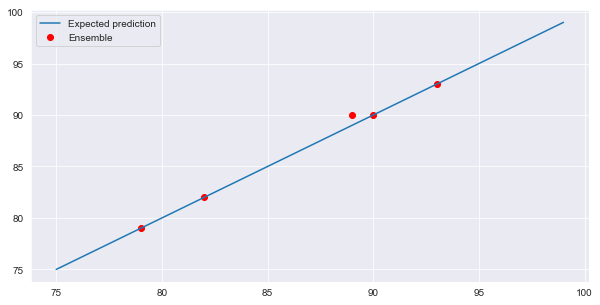

r2 score after ensemble:	 0.9927113702623906


In [84]:
plt.figure(figsize=(10,5))
plt.scatter(actual,prediction_ensemble, color='r',  label='Ensemble')
plt.plot(list(range(75,100)), list(range(75,100)), label='Expected prediction')
plt.legend()
plt.show()

print('r2 score after ensemble:\t',score_ensemble)

Looks good for the given years.

# Prediction of DTS and ANN Ensemble

In [85]:
print("Predcition of bloom date using ANN and DTS method ensemble ")
count=0
for t_year in test_years:
    monthap,datesap=day_month_calculator(t_year,prediction_ensemble[count])
    print('year: ',t_year, ' month:', monthap,' date: ',datesap,' days taken: ',prediction_ensemble[count])
    count=count+1

Predcition of bloom date using ANN and DTS method ensemble 
year:  1966  month: 3  date:  21  days taken:  79
year:  1971  month: 4  date:  1  days taken:  90
year:  1985  month: 4  date:  4  days taken:  93
year:  1994  month: 4  date:  1  days taken:  90
year:  2008  month: 3  date:  23  days taken:  82


***
## 4. Trends of the Sakura blooming phenomenon (20pts total)

### Problem 4-1: (20pts)
Based on the data from the past 60 years, investigate and discuss trends in the sakura hibernation ($D_{j}$) and blooming ($BD_{j}$) phenomena in Tokyo.

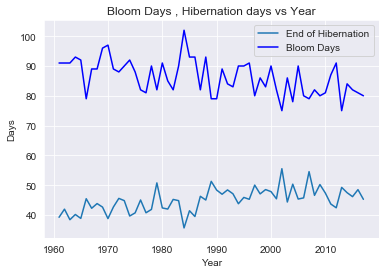

In [86]:
plt.figure(7)
plt.plot(years, list_end_hiber_date,label="End of Hibernation")
plt.plot(years,Bloom_dates,'-b',label='Bloom Days')
plt.xlabel('Year')
plt.ylabel('Days')
plt.title('Bloom Days , Hibernation days vs Year')
plt.legend()

        
        


Based on this we can say that Cherry trees end of hibernation to bloom got shorter in recent years then past years. This is probably due to decreased maximum temperature over the year. Sea resssure and local pressure might have changed the temparture pattern in recent years. Since the max temparature decressed the hibernation is taking more time now a days.